In [1]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D, GRU
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import os

#dark mode
#plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

TensorFlow 2.x selected.


In [0]:
#pip install kaggle --upgrade

In [0]:
os.environ['KAGGLE_USERNAME'] = "eddyalexander"
os.environ['KAGGLE_KEY'] = "fab67faf55645fb739e4a709ab71791c"

In [4]:
#https://www.kaggle.com/extralime/math-lectures
!kaggle datasets download extralime/math-lectures

math-lectures.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip -o 'math-lectures.zip'

Archive:  math-lectures.zip
  inflating: raw_text.csv            


In [6]:
os.listdir()

['.config', 'math-lectures.zip', 'raw_text.csv', 'sample_data']

In [0]:
def mapping(label):
     return dictionary[label.decode("utf-8")];
  #  return tf.Variable(dictionary[label.decode("utf-8")], tf.int16)

In [0]:
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy()[0])
  return encoded_text, label

In [0]:
def encode_map_fn(text, label):
  # py_func doesn't set the shape of the returned tensors.
  encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int64))
  # `tf.data.Datasets` work best if all components have a shape set
  #  so set the shapes manually: 
  encoded_text.set_shape([None])
  label.set_shape([])
  return encoded_text, label


In [0]:
def toTensorDataset(dataset):
  labels = dataset.pop('label')
  tensor_dataset = tf.data.Dataset.from_tensor_slices((dataset.values,labels.values))
  return tensor_dataset

In [0]:
# labels = lectures.pop('label')
# #Build Dataset
# dataset = tf.data.Dataset.from_tensor_slices((lectures.values,labels.values))
# #Check Dataset
# for feat, targ in dataset.take(5):
#   print ('Features: {}, Target: {}'.format(feat, targ))

In [0]:
lectures = pd.read_csv('raw_text.csv')
classNames = lectures['label'].unique()
# text = lectures['text'];
BUFFER_SIZE = 5000
BATCH_SIZE = 8
TAKE_SIZE = 5000
dictionary = {};
for i, cn in enumerate(classNames, start=1):
   dictionary[cn] = i
dictionary

dictionary = {
    'Probability': 0,
    'Linear Algebra': 1
}


In [13]:
for name in classNames:
  print('{}, {}'.format(name, lectures[lectures['label'] == name]['text'].count()))

Calculus, 70
Probability, 124
CS, 104
Algorithms, 81
Diff. Eq., 93
Linear Algebra, 152
AI, 48
Statistics, 79
Math for Eng., 28
Data Structures, 62
NLP, 19


In [0]:
chosen_ClassNames = ['Probability', 'Linear Algebra']
lectures = lectures[lectures['label'].isin(chosen_ClassNames)]

In [0]:
lectures = lectures.replace({"label":dictionary})

In [0]:
lectures['label'] = lectures['label'].astype(str).astype(int)

In [17]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 1 to 857
Data columns (total 2 columns):
text     276 non-null object
label    276 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.5+ KB


#Split Dataset

In [0]:
train, test = train_test_split(lectures, test_size=0.2)
# train, val = train_test_split(train, test_size=0.2)

In [19]:
print("Train count: {}".format(train.count()))
#print("Val Count: {}".format(val.count()))
print("Test Count: {}".format(test.count()))

Train count: text     220
label    220
dtype: int64
Test Count: text     56
label    56
dtype: int64


In [20]:
print("Train dataset")
train.info()

Train dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 137 to 673
Data columns (total 2 columns):
text     220 non-null object
label    220 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


In [21]:
print("Test dataset")
test.info()

Test dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 305 to 604
Data columns (total 2 columns):
text     56 non-null object
label    56 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.3+ KB


In [0]:
# print("Validation dataset")
# val.info()

In [0]:
#TensorFlow Dataset
train = toTensorDataset(train)
test =  toTensorDataset(test)
#val =  toTensorDataset(val)

In [25]:
for feat, targ in test.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b"The following content is\nprovided under a Creative Commons license. Your support will help MIT\nOpenCourseWare continue to offer high quality educational\nresources for free. To make a donation, or to view\nadditional materials from hundreds of MIT courses, visit\nMIT OpenCourseWare at ocw.mit.edu. PROFESSOR: Now, today\nwe are continuing with this last unit. Unit 5, continued. The informal title of this unit\nis Dealing With Infinity. That's really the extra little\npiece that we're putting in to our discussions of things like\nlimits and integrals. To start out with today, I'd\nlike to recall for you, L'Hopital's Rule. And in keeping with the spirit\nhere, we're just going to do the infinity / infinity case. I stated this a little\ndifferently last time, and I want to state it again today. Just to make clear what the\nhypotheses are and what the conclusion is. We start out with, really,\nthree hypotheses. Two of them are kind\nof obvious. The three hypotheses are that\n

#Encoder

In [0]:
tokenizer = tfds.features.text.Tokenizer()

In [0]:
vocabulary_set = set()
lectures.pop('label')
text = tf.data.Dataset.from_tensor_slices(lectures.values)
for text_tensor in text:
  some_tokens = tokenizer.tokenize(text_tensor.numpy()[0])
  vocabulary_set.update(some_tokens)
vocab_size = len(vocabulary_set)
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [0]:
train = train.map(encode_map_fn)
test = test.map(encode_map_fn)
#val = val.map(encode_map_fn)

In [29]:
input = train.take(1)
next(iter(input))

(<tf.Tensor: shape=(1298,), dtype=int64, numpy=array([ 6143, 16144,   120, ..., 14718, 16891,  1984])>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

#Decode

In [30]:
example_text = test.take(1);
example_text = next(iter(example_text))[0].numpy()
encoded_example = encoder.decode(example_text)
print(encoded_example)

The following content is provided under a Creative Commons license Your support will help MIT OpenCourseWare continue to offer high quality educational resources for free To make a donation or to view additional materials from hundreds of MIT courses visit MIT OpenCourseWare at ocw mit edu PROFESSOR Now today we are continuing with this last unit Unit 5 continued The informal title of this unit is Dealing With Infinity That s really the extra little piece that we re putting in to our discussions of things like limits and integrals To start out with today I d like to recall for you L Hopital s Rule And in keeping with the spirit here we re just going to do the infinity infinity case I stated this a little differently last time and I want to state it again today Just to make clear what the hypotheses are and what the conclusion is We start out with really three hypotheses Two of them are kind of obvious The three hypotheses are that f x tends to infinity g x tends to infinity that s what

#Model


In [31]:
train_shape = tuple(map(lambda x:x.shape,train.element_spec))
test_shape = tuple(map(lambda x:x.shape,test.element_spec))
#val_shape = tuple(map(lambda x:x.shape,val.element_spec))
train_shape, test_shape

((TensorShape([None]), TensorShape([])),
 (TensorShape([None]), TensorShape([])))

In [0]:
train_data = train.shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE, train_shape)
test_data = test.padded_batch(BATCH_SIZE, test_shape)
#val_data = test.padded_batch(BATCH_SIZE, val_shape)


In [33]:
for example_batch, label_batch in train_data.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)

Batch shape: (8, 10795)
label shape: (8,)
Batch shape: (8, 12526)
label shape: (8,)


In [0]:
EPOCHS = 4
STEPS_PER_EPOCH = 5
VALIDATION_STEPS = 1
BATCH_SIZE = 8

In [0]:
def train_m(model, epochs=EPOCHS):
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model.fit(train_data, epochs=epochs,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=test_data,
                      validation_steps=VALIDATION_STEPS
                      )

In [0]:
def plot_accuracy_and_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(10, 10))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1.0])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Cross Entropy')
  plt.ylim([0.0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [37]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(1, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          560192    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 609,985
Trainable params: 609,985
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = Sequential([
    Embedding(encoder.vocab_size, 32, mask_zero=True),
    GRU(64),
    Dense(1, activation='sigmoid')
])

Train for 5 steps, validate for 1 steps
Epoch 1/4
5/5 [==============================] - 97s 19s/step - loss: 0.6896 - accuracy: 0.6000 - val_loss: 0.6856 - val_accuracy: 0.6250
Epoch 2/4
5/5 [==============================] - 98s 20s/step - loss: 0.6913 - accuracy: 0.5750 - val_loss: 0.6807 - val_accuracy: 0.6250
Epoch 3/4
5/5 [==============================] - 88s 18s/step - loss: 0.7016 - accuracy: 0.4500 - val_loss: 0.6813 - val_accuracy: 0.6250
Epoch 4/4
5/5 [==============================] - 80s 16s/step - loss: 0.6883 - accuracy: 0.5500 - val_loss: 0.6812 - val_accuracy: 0.6250


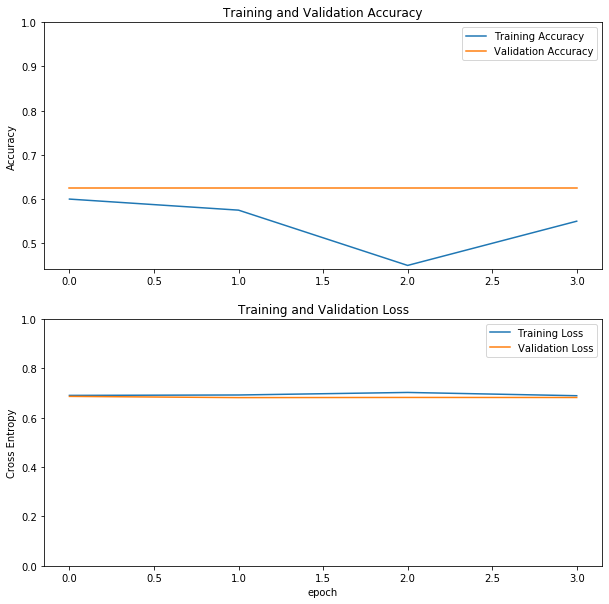

In [41]:
history = train_m(model)
plot_accuracy_and_loss(history)